# Submission by

| Name | RollNo |
|------|--------|
|Aman  | MDS202305|
|Ankan Kar  | MCS202303|
|Utpalraj Kemprai  | MDS202352|

---


## Importing the libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import os
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def seed_everything(seed=14):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(14)

## Dataloading and Visualization

In [3]:
# download the fashionmnist data from https://www.kaggle.com/datasets/zalando-research/fashionmnist

!kaggle datasets download -d zalando-research/fashionmnist
!unzip fashionmnist.zip

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 67% 46.0M/68.8M [00:00<00:00, 189MB/s]
100% 68.8M/68.8M [00:00<00:00, 212MB/s]
Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [4]:
# Load the datasets
train_df = pd.read_csv('/content/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/fashion-mnist_test.csv')

# Combine the datasets
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Separate labels and pixel data
labels = combined_df['label'].values
pixels = combined_df.drop('label', axis=1).values

In [5]:
# Convert to PyTorch tensors
labels = torch.tensor(labels, dtype=torch.long)
pixels = (torch.tensor(pixels, dtype=torch.float32) / 255.0)*2 - 1 # Normalize pixel values

In [6]:
# Create a TensorDataset
dataset = TensorDataset(pixels, labels)

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
# mapping labels to clothing
label_to_cloth = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

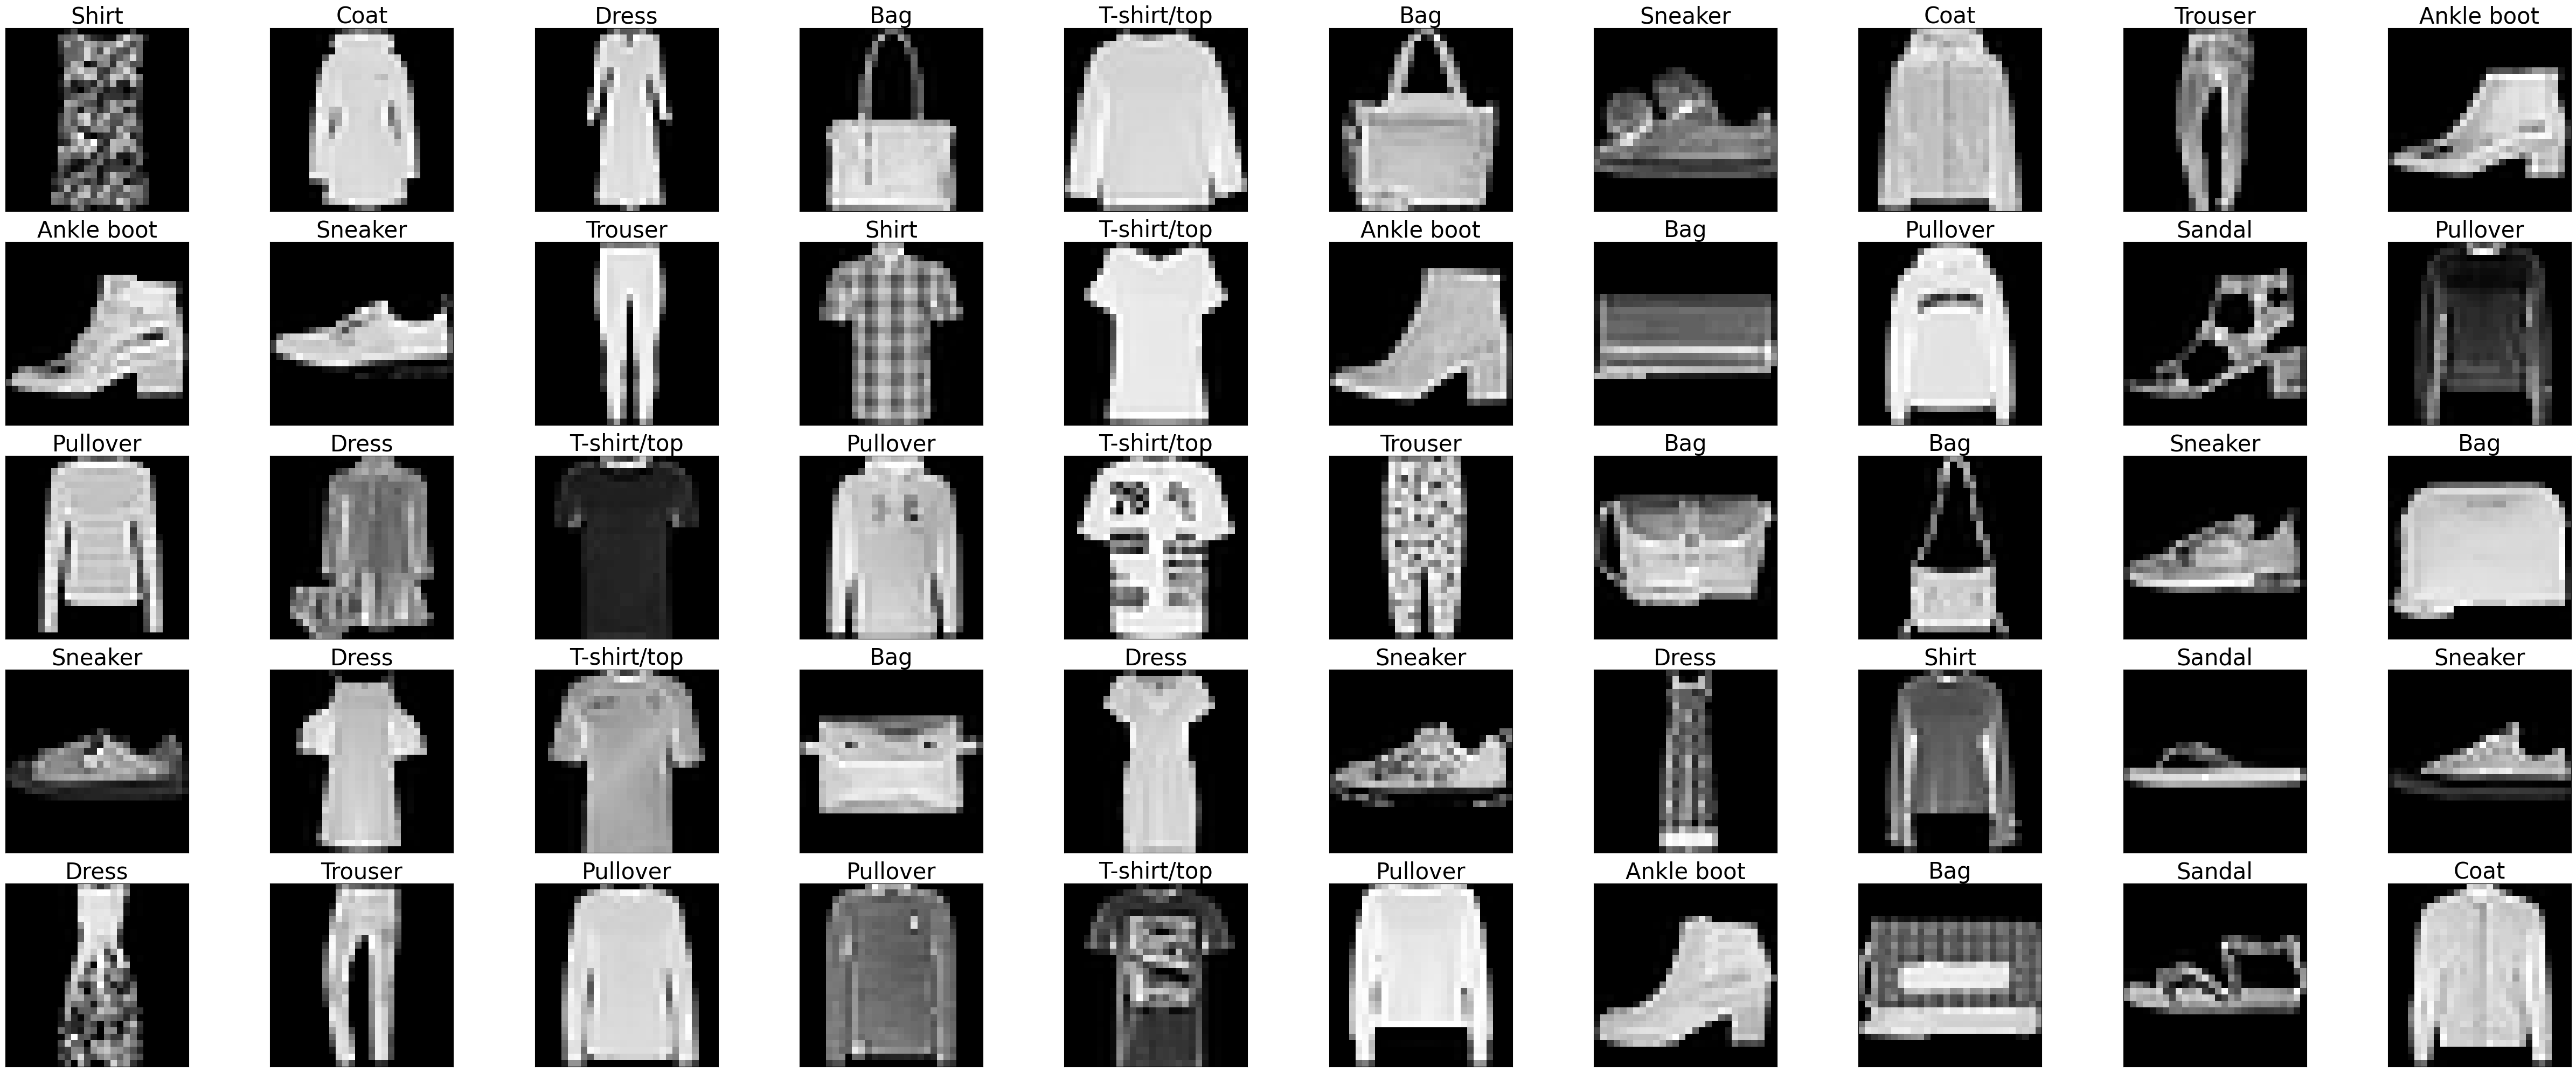

In [23]:
# Let's see if the train loader is working and sending us iterable images :)
# Also note that we converted images to tensor above with ToTensor(). Now we need to convert back to numpy to plot them

# obtain one batch of training images which means 64 images
dataiter = iter(dataloader)
img, label = next(dataiter) # _ for labels, Dataloader sends labels automatically as defined in Dataloader class.

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(50, 20))
plot_size=50 # gonna plot 30 images only
for idx in np.arange(plot_size):
    ax = fig.add_subplot(5, 10, idx+1, xticks=[], yticks=[])
    npimg = img[idx].numpy().reshape(28,28)
    plt.title(label_to_cloth[label[idx].item()],fontsize=30)
    plt.tight_layout()
    plt.imshow(npimg, cmap='gray')

In [9]:
#let's check the scaling
img = img[5]
print('Before scaling min: ', img.min())
print('Before scaling max: ', img.max())

Before scaling min:  tensor(-1.)
Before scaling max:  tensor(1.)


## Defining the Model

In [10]:
# Hyperparameters
latent_dim = 100  # Dimensionality of the noise vector
num_classes = 10  # Number of classes in Fashion MNIST
image_size = 28 * 28  # Flattened size of a 28x28 image
batch_size = 64
epochs = 50
img_channels = 1
learning_rate = 0.0002

In [11]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(

            nn.ConvTranspose2d(latent_dim + num_classes, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):

        label_embed = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)  # (batch, label_dim, 1, 1)
        noise = noise.unsqueeze(2).unsqueeze(3)  # (batch, z_dim, 1, 1)
        input = torch.cat([noise, label_embed], dim=1)  # Concatenate label and noise
        img = self.model(input)
        return img

In [12]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(

            nn.Conv2d(num_classes + 1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):

        label_embed = self.label_embedding(labels).unsqueeze(2).unsqueeze(3)  # (batch, label_dim, 1, 1)
        label_embed = label_embed.expand(-1, -1, img.size(2), img.size(3))  # Expand to match image size
        input = torch.cat([img, label_embed], dim=1)  # Concatenate label with image
        validity = self.model(input)
        return validity.view(-1, 1)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [14]:
# Initialize models, loss, and optimizers
generator = Generator(latent_dim, num_classes, image_size).to(device)
discriminator = Discriminator(num_classes, image_size).to(device)

# Initialize loss function
adversarial_loss = nn.BCELoss()

In [15]:
print(generator)

Generator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): ConvTranspose2d(110, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)


In [16]:
print(discriminator)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (model): Sequential(
    (0): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (6): Sigmoid()
  )
)


In [17]:
from torch import optim
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

## Training the model

In [18]:
# Training
losses = []
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.shape[0]

        # Prepare inputs for Discriminator
        real_imgs = imgs.view(batch_size, 1, 28, 28).to(device)
        labels = labels.to(device)
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
    losses.append((d_loss.item(), g_loss.item()))

    print(f"Epoch [{epoch + 1}/{epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

Epoch [1/50] - D Loss: 0.5968, G Loss: 0.8891
Epoch [2/50] - D Loss: 0.6958, G Loss: 0.5346
Epoch [3/50] - D Loss: 0.8400, G Loss: 0.5838
Epoch [4/50] - D Loss: 0.6526, G Loss: 0.7821
Epoch [5/50] - D Loss: 0.6827, G Loss: 0.7185
Epoch [6/50] - D Loss: 0.6439, G Loss: 0.8289
Epoch [7/50] - D Loss: 0.6694, G Loss: 0.6581
Epoch [8/50] - D Loss: 0.6963, G Loss: 0.8663
Epoch [9/50] - D Loss: 0.6930, G Loss: 0.6251
Epoch [10/50] - D Loss: 0.7250, G Loss: 0.7702
Epoch [11/50] - D Loss: 0.6997, G Loss: 0.6504
Epoch [12/50] - D Loss: 0.7075, G Loss: 0.6767
Epoch [13/50] - D Loss: 0.7013, G Loss: 0.7252
Epoch [14/50] - D Loss: 0.6858, G Loss: 0.6248
Epoch [15/50] - D Loss: 0.6243, G Loss: 0.8035
Epoch [16/50] - D Loss: 0.6365, G Loss: 0.7448
Epoch [17/50] - D Loss: 0.7174, G Loss: 0.6074
Epoch [18/50] - D Loss: 0.6698, G Loss: 0.7564
Epoch [19/50] - D Loss: 0.5990, G Loss: 0.9864
Epoch [20/50] - D Loss: 0.5622, G Loss: 1.0439
Epoch [21/50] - D Loss: 0.6546, G Loss: 0.7317
Epoch [22/50] - D Loss

### Plot of loss of Generator and Discriminator

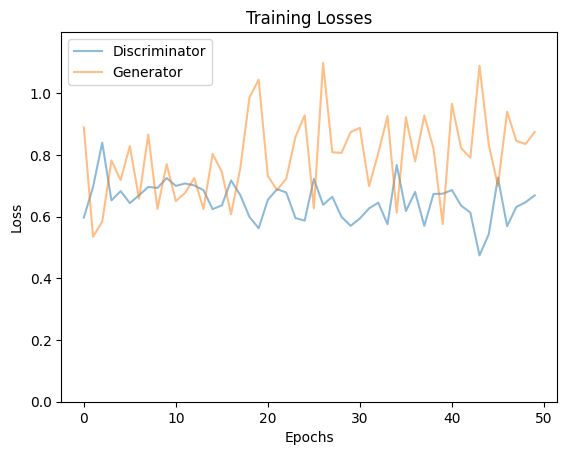

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.ylim(0, (losses.max() + 0.1))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Generating sample images from our trained model

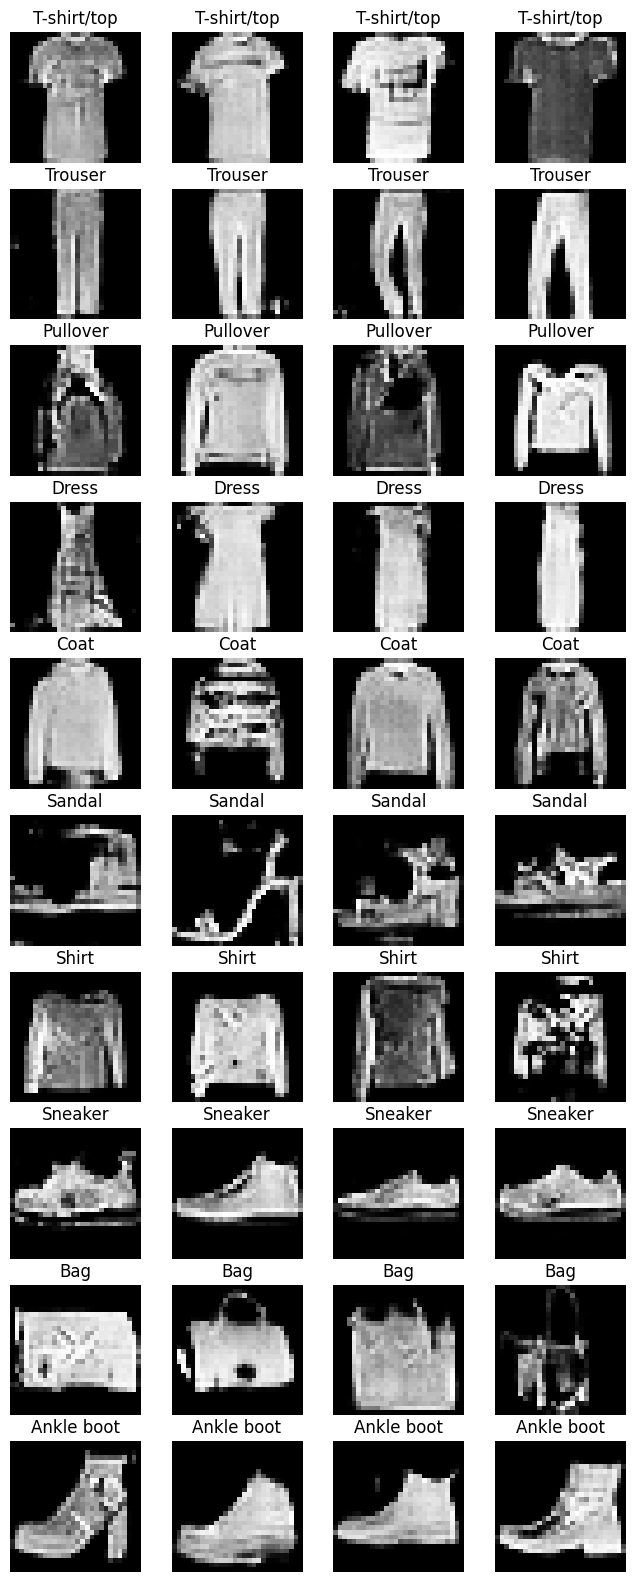

In [20]:
# Function to generate images for a specific label
def generate_examples(label, num_examples=4):
    z = torch.randn(num_examples, latent_dim).to("cuda")
    gen_labels = torch.tensor([label] * num_examples).to("cuda")
    with torch.no_grad():
        gen_imgs = generator(z, gen_labels).view(-1, 1, 28, 28).cpu()
    return gen_imgs

# Display generated images for each class
fig, axes = plt.subplots(num_classes, 4, figsize=(8, 20))
for label in range(num_classes):
    gen_imgs = generate_examples(label, num_examples=4)
    for i in range(4):
        axes[label, i].imshow(gen_imgs[i][0], cmap="gray")
        axes[label, i].axis("off")
        axes[label, i].set_title(f"{label_to_cloth[label]}")
plt.show()